# Feature engineering:

Consolidate and transform features to improve modeling results.

In [121]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy import stats
from scipy.special import boxcox

In [207]:
# import compensation dataset that I have cleaned & reduced in the  prior notebook
df = pd.read_csv('02.data/model_dataset.csv')

In [208]:
df.head()

,reportable_comp,subsection,state,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,gov_cluster_labels
0,198085.0,501(c)(6),ME,1995,734264,650527.0,1608376.0,1638630.0,56277,"Public, Societal Benefit",79,79,10,0,1052040,False,False,7,59
1,87550.0,501(c)(6),ME,1911,173021,89089.0,632341.0,603122.0,56277,"Public, Societal Benefit",20,20,8,100,397835,True,True,10,4
2,64575.0,501(c)(3),ME,1896,2283338,49470.0,846299.0,941058.0,56277,"Arts, Culture, and Humanities",17,17,6,50,215850,True,True,8,33
3,62180.0,501(c)(6),ME,1927,17316,0.0,208615.0,183721.0,56277,"Public, Societal Benefit",19,19,3,4,129714,True,True,9,44
4,130513.0,501(c)(6),ME,1952,831930,314175.0,1021331.0,1143753.0,56277,"Public, Societal Benefit",31,31,9,145,539848,True,True,12,16


### FEATURE ENGINEERING

#### Categorical features

In [209]:
# what are my categorical features
df.select_dtypes(include=['object']).head()

,subsection,state,ntee_categories
0,501(c)(6),ME,"Public, Societal Benefit"
1,501(c)(6),ME,"Public, Societal Benefit"
2,501(c)(3),ME,"Arts, Culture, and Humanities"
3,501(c)(6),ME,"Public, Societal Benefit"
4,501(c)(6),ME,"Public, Societal Benefit"


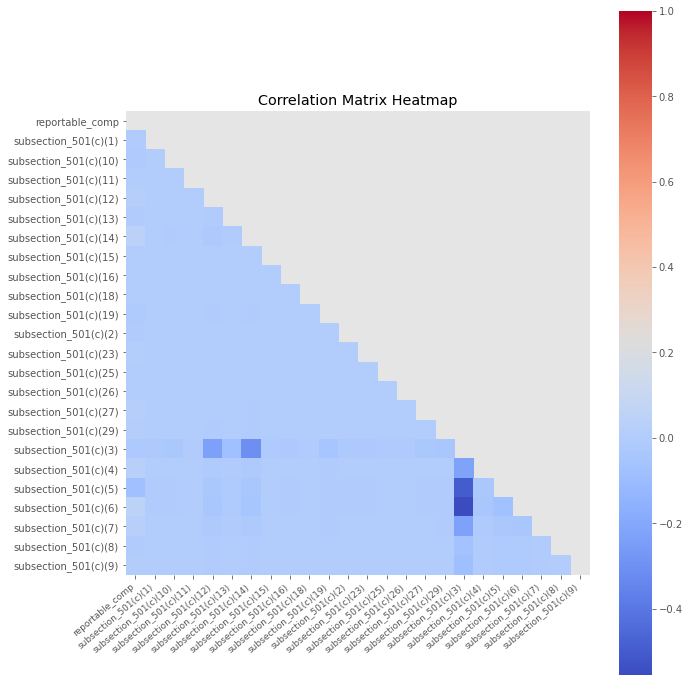

In [210]:
# show correlation heatmap comparing 
# target feature against subsection
plt.figure(figsize=(10, 10))

mask = np.zeros_like(pd.get_dummies(df[['reportable_comp', 'subsection']]).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df[['reportable_comp', 'subsection']]).corr(),
            cmap='coolwarm',
            annot=False,
            square=True,
            mask = mask)

plt.xticks(rotation=40, horizontalalignment="right", fontsize=9)

plt.title('Correlation Matrix Heatmap')

plt.tight_layout()
# plt.savefig('03.visualizations/501c_heatmap.png');

501c3 clearly seems to have the strongest relationship with other features.

In [211]:
# based on visual inspection above
# identify features to be combined
pd.get_dummies(df[['reportable_comp', 'subsection']]).corr().abs() \
.loc[:,'subsection_501(c)(3)'].sort_values(ascending=False).head(7).index

Index(['subsection_501(c)(3)', 'subsection_501(c)(6)', 'subsection_501(c)(5)',
       'subsection_501(c)(14)', 'subsection_501(c)(12)',
       'subsection_501(c)(7)', 'subsection_501(c)(4)'],
      dtype='object')

The top 7 seem to be quite closely related.

In [212]:
# concolidate subsections
for cat in pd.get_dummies(df[['reportable_comp', 'subsection']]).corr().abs() \
.loc[:,'subsection_501(c)(3)'].sort_values(ascending=False).head(7).index:
    df[cat] = df.subsection == cat[11:]

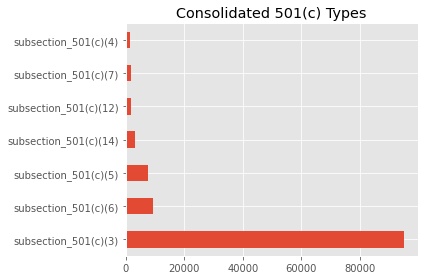

In [213]:
# how many subsections are in each category?
df.iloc[:, -7:].sum().plot(kind='barh')
plt.title('Consolidated 501(c) Types')
plt.tight_layout()
# plt.savefig('03.visualizations/501c_consolidated.png');

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

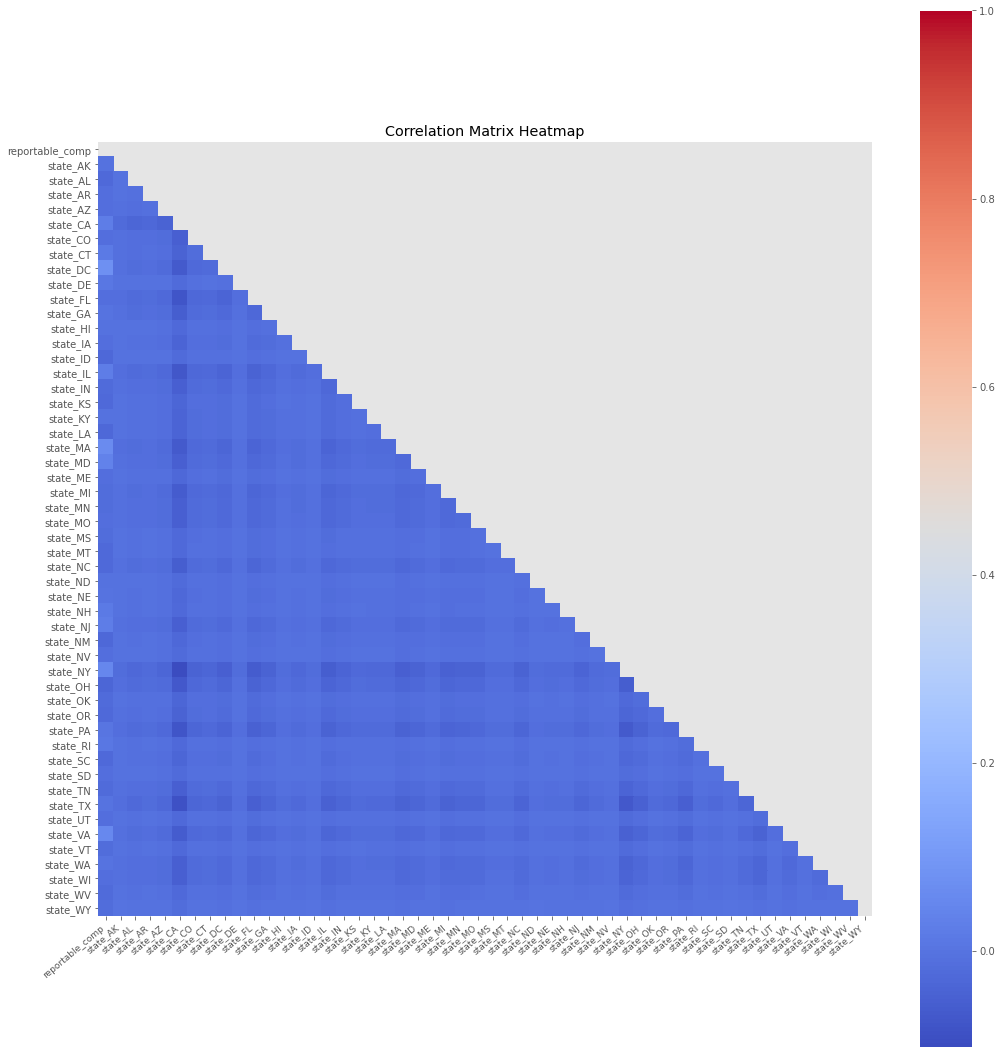

In [214]:
# show correlation heatmap comparing 
# target feature against state
plt.figure(figsize=(15, 15))

mask = np.zeros_like(pd.get_dummies(df[['reportable_comp', 'state']]).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df[['reportable_comp', 'state']]).corr(),
            cmap='coolwarm',
            annot=False,
#             vmin=-1,
            square=True,
            mask = mask)
plt.tight_layout()

plt.xticks(rotation=40, horizontalalignment="right", fontsize=9)

plt.title('Correlation Matrix Heatmap')

# plt.savefig('03.visualizations/states_consolidated.png');

Some states seem to be negatively and positively correlated with reportable compensation.

In [215]:
# positively correlated states
pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10)

reportable_comp    1.000000
state_DC           0.076012
state_MA           0.065091
state_VA           0.053791
state_NY           0.051975
state_MD           0.038223
state_IL           0.026317
state_NJ           0.024588
state_CA           0.023502
state_CT           0.015895
Name: reportable_comp, dtype: float64

In [216]:
# pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
# .loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:]

In [217]:
# consolidate positively correlated states
# using pca
sklearn_pca = PCA(n_components=2)

sklearn_pca.fit_transform(pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:])

sklearn_pca.explained_variance_ratio_

array([0.28887782, 0.19279878])

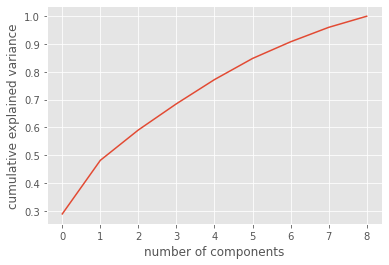

In [218]:
pca = PCA().fit(pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [219]:
df = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(pd.get_dummies(df[['reportable_comp', 'state']])[pd.get_dummies(df[['reportable_comp', 'state']]).corr() \
.loc[:,'reportable_comp'].sort_values(ascending=False).head(10).index].iloc[:, 1:]), 
             columns = ['pca_states_1', 
                      'pca_states_2']),
    df], axis=1)

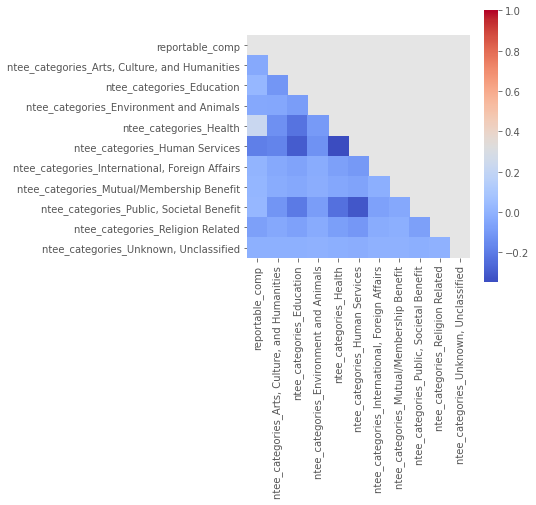

In [220]:
# show correlation heatmap comparing 
# target feature against ntee categories
plt.figure(figsize=(5, 5))

mask = np.zeros_like(pd.get_dummies(df[['reportable_comp', 'ntee_categories']]).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df[['reportable_comp', 'ntee_categories']]).corr(),
            cmap='coolwarm',
            annot=False,
#             vmin=-1,
            square=True,
            mask = mask);

Since I'm seeing quite a bit of distribution in correlation for this feature, I will not consolidate with PCA.

In [221]:
# drop features that have been
# consolidated with PCA
df.drop(['state',
       'subsection'], axis=1, inplace=True)

### Continuous features correlations

Because of the strong skew in continuous features, I will windsorize outliers and transform with box-cox.

In [222]:
df.head()

,pca_states_1,pca_states_2,reportable_comp,formation_yr,assets,liabilities,expenses,revenue,state_median_income,ntee_categories,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,salaries_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,gov_cluster_labels,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(12),subsection_501(c)(7),subsection_501(c)(4)
0,-0.085261,-0.082864,198085.0,1995,734264,650527.0,1608376.0,1638630.0,56277,"Public, Societal Benefit",79,79,10,0,1052040,False,False,7,59,False,True,False,False,False,False,False
1,-0.085261,-0.082864,87550.0,1911,173021,89089.0,632341.0,603122.0,56277,"Public, Societal Benefit",20,20,8,100,397835,True,True,10,4,False,True,False,False,False,False,False
2,-0.085261,-0.082864,64575.0,1896,2283338,49470.0,846299.0,941058.0,56277,"Arts, Culture, and Humanities",17,17,6,50,215850,True,True,8,33,True,False,False,False,False,False,False
3,-0.085261,-0.082864,62180.0,1927,17316,0.0,208615.0,183721.0,56277,"Public, Societal Benefit",19,19,3,4,129714,True,True,9,44,False,True,False,False,False,False,False
4,-0.085261,-0.082864,130513.0,1952,831930,314175.0,1021331.0,1143753.0,56277,"Public, Societal Benefit",31,31,9,145,539848,True,True,12,16,False,True,False,False,False,False,False


In [223]:
# cap at 99th percentile
for column in df[['assets', 
               'liabilities', 
               'employee_tot_ct', 
               'revenue', 
               'salaries_expense_tot_curyr', 
               'expenses',
               'volunteer_tot_ct']].columns:
    df[column].clip(upper=df[column].quantile(.99), inplace=True)

In [224]:
# using fit_transform on features that
# I consolidated with PCA hurt performance.
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses']].columns:
#     df[column] = preprocessing.StandardScaler().fit_transform(np.array(df[column]).reshape(-1, 1))

In [225]:
# box-cox requires only positive values
# how many organizations are there with negative values?
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses']].columns:
#     if df[df[column] <= 0].shape[0] > 0:
#         print(column + ' -', df[df[column] <= 0].shape[0])

In [226]:
# drop compensation with negative values
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses']].columns:
#     if df[df[column] <= 0].shape[0] > 0:
#         df.drop(df[df[column] <= 0].index, axis=0, inplace=True)

In [227]:
# transform features with boxcox
# for column in df[['assets', 
#                'liabilities', 
#                'employee_tot_ct', 
#                'revenue', 
#                'salaries_expense_tot_curyr', 
#                'expenses']].columns:
#     df[column] = stats.boxcox(df[column])[0]

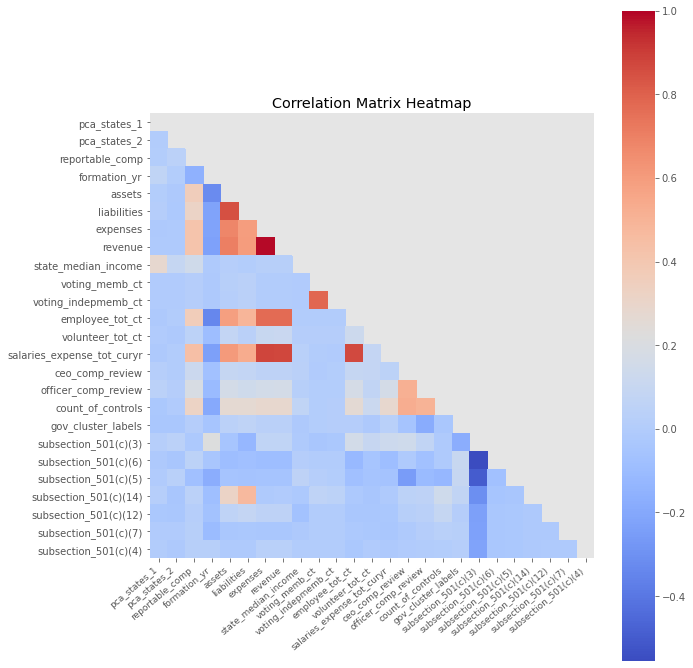

In [228]:
plt.figure(figsize=(10, 10))

mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(),
            cmap='coolwarm',
            annot=False,
            square=True,
            mask = mask)

plt.title('Correlation Matrix Heatmap')

plt.xticks(rotation=40, horizontalalignment="right", fontsize=9)

plt.tight_layout()
# plt.savefig('03.visualizations/cont_features_heatmap.png');

A number of continuous features are very strongly positively correlated with reportable compensation.

In [229]:
# based on visual inspection above
# identify features to be combined
df.corr().loc[:,'assets'].sort_values(ascending=False).head(10)

assets                        1.000000
liabilities                   0.853011
revenue                       0.706954
expenses                      0.681358
salaries_expense_tot_curyr    0.608968
employee_tot_ct               0.592234
reportable_comp               0.359771
subsection_501(c)(14)         0.314763
count_of_controls             0.268767
officer_comp_review           0.162422
Name: assets, dtype: float64

The top 7 seem to be quite closely related.

In [230]:
# consolidate financial features
sklearn_pca = PCA(n_components=3)

sklearn_pca.fit_transform(df[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses'
                              ]])
sklearn_pca.explained_variance_ratio_

array([0.85407864, 0.1083571 , 0.03338439])

In [231]:
# combine pca features and
# remaining features
sklearn_pca = PCA(n_components=3)

df = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(df[['assets', 
                              'liabilities', 
                              'employee_tot_ct', 
                              'revenue',
                               'salaries_expense_tot_curyr', 
                              'expenses']]), 
             columns = ['pca_1_financial', 
                      'pca_2_financial',
                       'pca_3_financial']),
    df[[i for i in list(df.columns) if i not in ['assets', 
                      'liabilities', 
                      'employee_tot_ct', 
                      'revenue',
                       'salaries_expense_tot_curyr', 
                      'expenses']]].reset_index(drop=True)
], axis=1)

In [232]:
# time_start = time.time()

# umap_results = umap.UMAP().fit_transform(df[['assets', 
#   'liabilities', 
#   'employee_tot_ct', 
#   'revenue',
#    'salaries_expense_tot_curyr', 
#   'expenses']])

# print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [233]:
# pd.DataFrame(umap_results).rename({0:'umap_1', 1:'umap_2'}, axis=1)

In [234]:
# df = pd.concat([
#     pd.DataFrame(umap_results).rename({0:'umap_1', 1:'umap_2'}, axis=1),
#     df[[i for i in list(df.columns) if i not in ['assets', 
#                       'liabilities', 
#                       'employee_tot_ct', 
#                       'revenue',
#                        'salaries_expense_tot_curyr', 
#                       'expenses']]].reset_index(drop=True)], axis=1)

In [235]:
# consolidate voting member features
sklearn_pca = PCA(n_components=1)

sklearn_pca.fit_transform(df[['voting_indepmemb_ct', 
                              'voting_memb_ct']])
sklearn_pca.explained_variance_ratio_

array([0.8929501])

In [236]:
df = pd.concat([
    pd.DataFrame(data = sklearn_pca.fit_transform(df[['voting_indepmemb_ct', 
                              'voting_memb_ct']]), 
             columns = ['pca_voting_members']),
    df[[i for i in list(df.columns) if i not in ['voting_indepmemb_ct', 
                              'voting_memb_ct']]].reset_index(drop=True)
], axis=1)

### Final correlation comparison

In [237]:
df.head()

,pca_voting_members,pca_1_financial,pca_2_financial,pca_3_financial,pca_states_1,pca_states_2,reportable_comp,formation_yr,state_median_income,ntee_categories,volunteer_tot_ct,ceo_comp_review,officer_comp_review,count_of_controls,gov_cluster_labels,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(12),subsection_501(c)(7),subsection_501(c)(4)
0,74.050274,-1.199791e+08,-1.331946e+07,1.615708e+06,-0.085261,-0.082864,198085.0,1995,56277,"Public, Societal Benefit",0.0,False,False,7,59,False,True,False,False,False,False,False
1,-9.388241,-1.213139e+08,-1.436152e+07,1.265620e+06,-0.085261,-0.082864,87550.0,1911,56277,"Public, Societal Benefit",100.0,True,True,10,4,False,True,False,False,False,False,False
2,-13.630878,-1.194427e+08,-1.483889e+07,3.399028e+05,-0.085261,-0.082864,64575.0,1896,56277,"Arts, Culture, and Humanities",50.0,True,True,8,33,True,False,False,False,False,False,False
3,-10.802453,-1.217537e+08,-1.486031e+07,1.215794e+06,-0.085261,-0.082864,62180.0,1927,56277,"Public, Societal Benefit",4.0,True,True,9,44,False,True,False,False,False,False,False
4,6.168092,-1.203954e+08,-1.405536e+07,1.217032e+06,-0.085261,-0.082864,130513.0,1952,56277,"Public, Societal Benefit",145.0,True,True,12,16,False,True,False,False,False,False,False


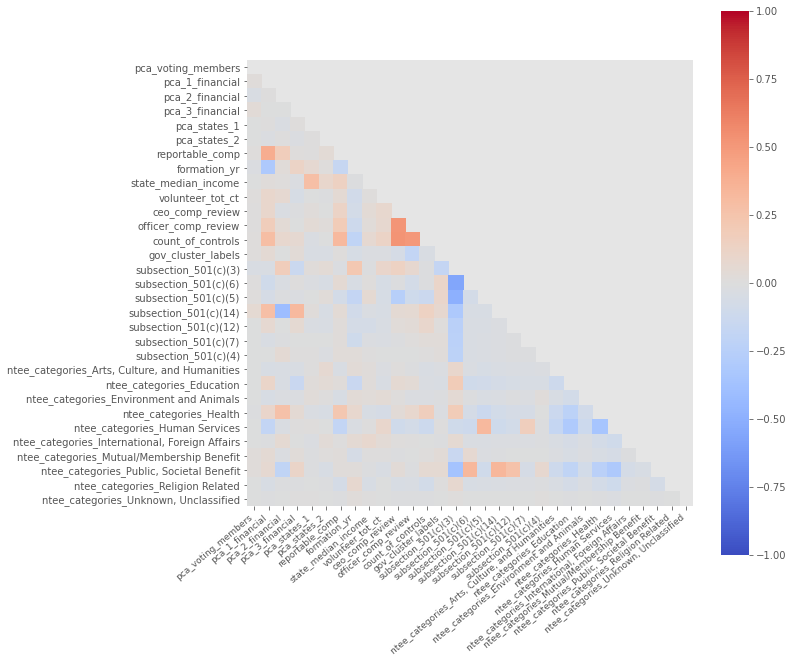

In [238]:
# show correlation heatmap, only displaying one half
# so information isn't duplicated
plt.figure(figsize=(10, 10))

mask = np.zeros_like(pd.get_dummies(df).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(pd.get_dummies(df).corr(),
            vmin=-1,
            cmap='coolwarm',
#             cmap="Blues",
            annot=False,
            square=True,
            mask = mask)

plt.xticks(rotation=40, horizontalalignment="right", fontsize=9);

Almost all correlated features have been consolidated.

### Export dataset with feature adjustments

In [239]:
df.shape

(120512, 22)

In [240]:
# remove target feature and 
# export features for modeling
df.to_csv('02.data/model_dataset_features_eng.csv', index=False)